In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# DL-CI-build dataset (lstm)
columns = ['build_Failed', 'gh_is_pr', 'git_prev_commit_resolution_status',
    'gh_team_size', 'gh_num_commit_comments', 'git_diff_src_churn',
    'git_diff_test_churn', 'gh_diff_files_added', 'gh_diff_files_deleted',
    'gh_diff_files_modified', 'gh_diff_tests_added',
    'gh_diff_tests_deleted', 'gh_diff_src_files', 'gh_diff_doc_files',
    'gh_diff_other_files', 'gh_sloc', 'gh_test_lines_per_kloc',
    'gh_test_cases_per_kloc', 'gh_asserts_cases_per_kloc', 'tr_build_id',
    'gh_build_started_at']

path = '/mnt/d/PFE/Code/CI-Failing-Builds-Detection/dataset'
path = '/content/drive/MyDrive/CI/replicating-ets/DL-CIBuild/dataset'
valid_proj = 'ruby.csv'
cols_to_keep = 18

# skipCI dataset
columns = ['ci_skipped', 'ns', 'nd', 'nf', 'entropy', 'la', 'ld', 'lt', 'ndev',
       'age', 'nuc', 'exp', 'rexp', 'sexp', 'TFC', 'is_doc', 'is_build',
       'is_meta', 'is_media', 'is_src', 'is_merge', 'FRM', 'COM', 'CFT',
       'classif', 'prev_com_res', 'proj_recent_skip', 'comm_recent_skip',
       'same_committer', 'is_fix', 'day_week', 'CM', 'commit_hash']

path = '/content/drive/MyDrive/CI/SkipCI-dataset'
path = '/mnt/d/PFE/Papers Presentations/1SkipCI/SkipCI/dataset/'
valid_proj = 'candybar-library.csv'
cols_to_keep = 32

# projects list: 
# candybar-library.csv  GI.csv               mtsar.csv     ransack.csv     SemanticMediaWiki.csv
# contextlogger.csv     grammarviz2_src.csv  parallec.csv  SAX.csv         solr-iso639-filter.csv
# future.csv            groupdate.csv        pghero.csv    searchkick.csv  steve.csv


#### Validation on all data

In [2]:
df = pd.DataFrame(columns=columns, dtype='object')

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename[-4:]==".csv":
            df = pd.concat([df, pd.read_csv(os.path.join(dirname, filename))])

X = df.iloc[:,1:cols_to_keep]
y = df.iloc[:,0].astype(int)

X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y, random_state=42) # keep ratio of classes in split

eval_meth = 'eval_on_all_data'

#### Within project validation

In [3]:
def within_eval(valid_proj):
    df = pd.read_csv(os.path.join(path, valid_proj))
    X = df.iloc[:,1:cols_to_keep]
    y = df.iloc[:,0].astype(int)

    X_train, X_val , y_train, y_val = train_test_split(np.array(X), np.array(y), test_size=0.2, shuffle=True, stratify=y, random_state=seed) # keep ratio of classes in split

    eval_meth = f'within_proj_{valid_proj}'[:-4]

    return X_train, y_train, X_val, y_val, df, eval_meth

#### Cross project validation

In [4]:
def cross_eval(valid_proj):

    df_train = pd.DataFrame(columns=columns, dtype='object')
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename[-4:]==".csv" and filename!=valid_proj:
                df_train = pd.concat([df_train, pd.read_csv(os.path.join(dirname, filename))])

    X_train = np.array(df_train.iloc[:,1:cols_to_keep])
    y_train = np.array(df_train.iloc[:,0].astype(int))

    df_val = pd.read_csv(os.path.join(path, valid_proj))

    X_val = np.array(df_val.iloc[:,1:cols_to_keep])
    y_val = np.array(df_val.iloc[:,0].astype(int))

    eval_meth = f'cross_proj_{valid_proj}'[:-4]

    return X_train, y_train, X_val, y_val, df_val, eval_meth

### Modifiable Decision Tree model 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix


class modDecisionTree:
    """
    Represents the classification model
    based on sklearn implementation with added methods for modifying single nodes
    nodes are indexed depth first
    """


    def __init__(self, max_depth=3, random_state=42):
        # need to add init of other hyper-param
        self.max_depth = max_depth
        self.model = DecisionTreeClassifier(max_depth=max_depth, splitter='random', random_state=random_state)
    

    def fit(self, X_train, y_train, columns_names):
        self.model.fit(X_train, y_train)
        self.tree = self.model.tree_
        self.n_nodes = self.tree.node_count       # nbr of nodes
        self.features = self.tree.feature         # list of each node's feature
        self.thresholds = self.tree.threshold     # list of each node's threshold
        self.columns_names = columns_names
        self.features_names = [list(self.columns_names)[i] for i in self.features]
        self.nodes_type = self.get_nodes_type()  # a node is either a split node or a terminal node/leaf


    def evaluate(self, X_val, y_val, reward_only=True, print_confusion=False):
        y_pred = self.model.predict(X_val)
        metrics = {}
        metrics['F1'] = f1_score(y_val, y_pred)
        if not reward_only:
            metrics['recall'] = recall_score(y_val, y_pred)
            metrics['precision'] = precision_score(y_val, y_pred)
            metrics['accuracy'] = accuracy_score(y_val, y_pred)
            metrics['AUC'] = roc_auc_score(y_val, y_pred)
        if print_confusion:
            print(confusion_matrix(y_val, y_pred))
        return metrics


    def feature_importance(self):
        feat_imp = []
        for name, importance in zip(self.features_names , self.model.feature_importances_):
            feat_imp.append((name, importance))
        feat_imp.sort(key=lambda t:t[1], reverse=True)
        return feat_imp


    def plot_tree(self):
        plt.figure(figsize=(15,10))  # set plot size (denoted in inches)
        tree.plot_tree(self.model, fontsize=10, class_names=['pass','fail'])
        plt.show()


    def get_nodes_type(self):
        children_left = self.tree.children_left
        children_right = self.tree.children_right
        node_depth = np.zeros(shape=self.n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=self.n_nodes, dtype=bool)
        stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
        while len(stack) > 0:
            # 'pop' ensures each node is only visited once
            node_id, depth = stack.pop()
            node_depth[node_id] = depth
            # If the left and right child of a node is not the same we have a split node
            is_split_node = children_left[node_id] != children_right[node_id]
            # If a split node, append left and right children and depth to `stack`
            # so we can loop through them
            if is_split_node:
                stack.append((children_left[node_id], depth + 1))
                stack.append((children_right[node_id], depth + 1))
            else:
                is_leaves[node_id] = True
        return is_leaves


    def node_is_leaf(self, node):
        """Returns whether a node is a leaf (terminal node) or a split node"""
        return self.nodes_type[node]==1


    def set_node_threshold(self, node, value):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a leaf node's threshold.")
            return
        self.thresholds[node] = value 


    def set_node_feature(self, node, feat_index=None, feat_name=None):
        if node>=self.tree.node_count:
            print("Error: selected node id is not in the tree.")
            return
        if self.node_is_leaf(node):
            print("Error: can't change a terminal node's feature.")
            return
        # convert feature name to index if supplied with name
        if feat_index==None:
            feat_index = self.features_names.index(feat_name)
        self.features[node] = feat_index

### State Generation

#### Meth1

In [6]:
def tree_convolution_1(model, features, thresholds, node=0):
    """
        convolution of each 3 nodes, with overlapping => child of 1 subtree is parent of the next
        => after each conv, slit nodes' featuress and thresholdss are updated and terminal nodes are removed
        returns new features,thresholds values as lists
    """
    visited = []
    queue = []
    visited.append(node)
    queue.append(node)
    new_features = features
    new_thresholds = thresholds

    # BFS traversal
    while queue:
        node = queue.pop(0) 
        left_node = model.tree.children_left[node]
        right_node = model.tree.children_right[node]
        #print (node, left_node, right_node, end = "\n")
        if left_node not in visited:
            visited.append(left_node)
            queue.append(left_node)
        if right_node not in visited:
            visited.append(right_node)
            queue.append(right_node)

        # define kernel here
        if features[left_node]==-2 and features[right_node]==-2: # both child nodes are leaves
            new_node_features = -2
            new_node_thresholds = 0
        elif features[left_node]==-2: # left node is leaf
            new_node_features = (features[node]+features[right_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[right_node])/2
        elif features[right_node]==-2: # right node is leaf
            new_node_features = (features[node]+features[left_node])/2
            new_node_thresholds = (thresholds[node]+thresholds[left_node])/2
        else:
            new_node_features = (features[node]+features[left_node]+features[right_node])/3
            new_node_thresholds = (thresholds[node]+thresholds[left_node]+thresholds[right_node])/3
        # save new values
        new_features[node] = new_node_features # will auto convert to int 
        new_thresholds[node] = new_node_thresholds

    return new_features, new_thresholds

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def flatten(features, thresholds):
    # removing null values
    # clean_feat, clean_thres = [], []
    # for i in range(len(features)):
    #     if features[i]!=-2:
    #         clean_feat.append(features[i])
    #         clean_thres.append(thresholds[i])
    # return torch.cat((torch.FloatTensor(clean_feat), torch.FloatTensor(clean_thres))).to(device)

    return torch.cat((torch.tensor(features!=-2, device=device), torch.tensor(thresholds!=-2,device=device)))


def generate_state_1(model, features, thresholds, nbr_of_conv=0):
    """ for this method, we just concat the features and thresholds vectors, without applying convolution"""
    features, thresholds = features.copy(), thresholds.copy()
    for _ in range(nbr_of_conv): 
        new_features, new_thresholds = tree_convolution_1(model, features, thresholds) # model must be fitted
        features, thresholds = new_features, new_thresholds
    return flatten(features, thresholds)
    


#### Meth2: 1 hot enc

In [7]:
from sklearn.preprocessing import OneHotEncoder


def tree_convolution_2(model, encoded_nodes, number_of_attributes, node=0):
    """
        convolution of each 3 nodes, with overlapping => child of 1 subtree is parent of the next
        => after each conv, slit nodes' featuress and thresholdss are updated and terminal nodes are removed
        takes a 1 hot representation of a tree and returns it after one convolution (same shape)
    """
    new_encoded_nodes = encoded_nodes.copy()
    
    visited = []
    queue = []
    visited.append(node)
    queue.append(node)
    # BFS traversal
    while queue:
        node = queue.pop(0) 
        left_node = model.tree.children_left[node]
        right_node = model.tree.children_right[node]
        #print (node, left_node, right_node, end = "\n")
        if left_node not in visited:
            visited.append(left_node)
            queue.append(left_node)
        if right_node not in visited:
            visited.append(right_node)
            queue.append(right_node)

        # define kernel here
        if encoded_nodes[left_node] is None and encoded_nodes[right_node] is None: # both child nodes are leaves
            new_enc_node = None
        elif encoded_nodes[left_node] is None: # left node is leaf
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[right_node]
            new_enc_node = node_aggregate(number_of_attributes, vect1, vect2)
        elif encoded_nodes[right_node] is None: # right node is leaf
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[left_node]
            new_enc_node = node_aggregate(number_of_attributes, vect1, vect2)
        else:
            vect1 = encoded_nodes[node]
            vect2 = encoded_nodes[left_node]
            vect3 = encoded_nodes[right_node]
            new_enc_node = node_aggregate(number_of_attributes, vect1, vect2, vect3)
        # save new values
        new_encoded_nodes[node] = new_enc_node

    return new_encoded_nodes


def node_aggregate(number_of_attributes, vect1, vect2, vect3=None):
    """
        given 2 or 3 vectors,
        for all attributes
        if all vectors contain the same attribute, this will average them
        else it will keep the non null value
    """
    out = vect1
    if vect3 is None:
        for i in range(number_of_attributes):
            if vect1[i]!=0 and vect2[i]==0:
                out[i] = vect1[i]
            if vect1[i]!=0 and vect2[i]!=0:
                out[i] = (vect1[i]+vect2[i])/2
    else:
        for i in range(number_of_attributes):
            if vect1[i]==0:
                if vect2[i]!=0 and vect3[i]!=0:
                    out[i] = (vect2[i]+vect3[i])/2
                if vect2[i]==0 and vect3[i]!=0:
                    out[i] = vect3[i]
                if vect2[i]!=0 and vect3[i]==0:
                    out[i] = vect2[i]

            else:
            # if vect1[i]!=0:
                if vect2[i]!=0 and vect3[i]!=0:
                    out[i] = (vect1[i]+vect2[i]+vect3[i])/2
                if vect2[i]==0 and vect3[i]!=0:
                    out[i] = (vect1[i]+vect3[i])/2
                if vect2[i]!=0 and vect3[i]==0:
                    out[i] = (vect1[i]+vect2[i])/2
    return out


def encode_tree(model, number_of_attributes):
    """
        Creates a vector representation to a decision tree
        each node is represented by a 1 hot vector containing the threshold at the attribute's index
        output is 1D Tensor of node representations
    """
    # fit 1 hot encoder
    enc = OneHotEncoder()
    arr = np.array(range(number_of_attributes)).reshape(-1, 1)
    enc.fit(arr)

    # build init vect
    n = len(model.features)
    encoded_nodes = []
    for i in range(n):
        feat, thres = model.features[i], model.thresholds[i]
        if feat==-2:
            encoded_nodes.append(None)
            continue
        enc_node = enc.transform([[feat]])*thres
        encoded_nodes.append(enc_node.toarray()[0])

    return encoded_nodes


def shorten_state(encoded_nodes, number_of_attributes):
    # finding the new state size
    n = len(encoded_nodes)
    out_size = n*number_of_attributes
    for node in encoded_nodes:
        if node is None:
            out_size -= number_of_attributes
    
    out = torch.zeros(out_size, device=device)
    
    # removing None values / terminal nodes
    k = -1
    for i in range(n):
        node = encoded_nodes[i]
        if node is None:
            continue
        k += 1
        for j in range(number_of_attributes):
            out[k * number_of_attributes + j] = node[j]
    return out


def generate_state_2(model, nbr_of_conv, number_of_attributes):
    encoded_nodes = encode_tree(model, number_of_attributes)
    for _ in range(nbr_of_conv):
        new_encoded_nodes = tree_convolution_2(model, encoded_nodes, number_of_attributes) # model must be fitted
        encoded_nodes = new_encoded_nodes
    return shorten_state(encoded_nodes, number_of_attributes)

#### Choose Convolution Method

In [8]:
use_meth_1 = True

def generate_state(model, features, thresholds, nbr_of_conv, use_meth_1, number_of_attributes):
    """ Choose which convolution method to use"""
    if use_meth_1:
        return generate_state_1(model, features, thresholds, nbr_of_conv=0)
    else:
        return generate_state_2(model, nbr_of_conv, number_of_attributes)

### RL Agent Definition

In [9]:
import numpy as np
import random

from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
#from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
class ThresholdsNetwork(nn.Module):
    """Network that will predict the new thresholds vector given a state."""


    def __init__(self, state_size, threshold_vector_size, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            threshold_vector_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the hidden layer
        """
        super(ThresholdsNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer_norm = nn.LayerNorm(state_size)
        self.fc1 = nn.Linear(state_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, threshold_vector_size)


    def forward(self, state):
        x = self.layer_norm(state)
        x = F.relu(self.fc1(x), inplace=True)
        #x = F.relu(self.fc2(x), inplace=True)
        out = F.relu(self.fc3(x))
        return out
    

    def get_thresholds_vector(self, state):
        threshold_vector = self.forward(state)#.to(device)
        return threshold_vector

In [11]:
class AttributeNetwork(nn.Module):
    """Network that will select a new attribute for a tree node given the environment state and thresholds vector"""

    def __init__(self, state_size, threshold_vector_size, number_of_attributes, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            threshold_vector_size (int): Dimension of each threshold vector
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network's hidden layer

        """
        super(AttributeNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer_norm = nn.LayerNorm(state_size + threshold_vector_size)
        self.fc1 = nn.Linear(state_size + threshold_vector_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, number_of_attributes)


    def forward(self, state, threshold_vector):
        """Build a critic (attribute) network that maps (state, threshold_vector) pairs -> Q-values for each attribute."""
        x = torch.cat((state, threshold_vector), dim=-1)
        x = self.layer_norm(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))


    def get_attributes_vector(self, state, threshold_vector, Xe_vect=False):
        if not Xe_vect:
            attributes_vector = self.forward(state, threshold_vector)

        else:
            # the input threshold vector is Xe instead of X
            # decompose (st,X) input into (st,Xe_k) for each k 
            attributes_vector = torch.zeros(len(threshold_vector), device=device)
            X = threshold_vector
            for k in range(len(X)):
                Xe = torch.zeros(len(X), device=device)    
                Xe[k] = X[k]
                q_vect = self.forward(state,Xe)
                attributes_vector[k] = q_vect[k]
        return attributes_vector

In [12]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""


    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.vstack([e.state for e in experiences if e is not None]).float().to(device)
        actions = torch.vstack([torch.tensor(e.action) for e in experiences if e is not None]).float().to(device)
        rewards = torch.vstack([torch.tensor(e.reward) for e in experiences if e is not None]).float().to(device)
        next_states = torch.vstack([e.next_state for e in experiences if e is not None]).float().to(device)
        dones = torch.vstack([torch.tensor(e.done) for e in experiences if e is not None]).float().to(device)
        return zip(states, actions, rewards, next_states, dones)


    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

In [13]:
import dill as pickle

class Agent():
    """Interacts with and learns from the environment."""
    

    def __init__(self, state_size, threshold_vector_size, number_of_attributes, random_seed, hidden_size, lr_actor, lr_critic, buffer_size, batch_size, gamma, curdir):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            threshold_vector_size (int): dimension of each threshold vector
            random_seed (int): random seed
            add rest
        """
        self.state_size = state_size
        self.threshold_vector_size = threshold_vector_size
        self.number_of_attributes = number_of_attributes
        self.seed = random.seed(random_seed)
        self.gamma = gamma
        self.curdir = curdir
        print("Using: ", device)

        # Thresholds Network 
        self.ThresholdsNetwork = ThresholdsNetwork(state_size, threshold_vector_size, random_seed, hidden_size).to(device)
        self.optimizer_ThresholdsNetwork = optim.Adam(self.ThresholdsNetwork.parameters(), lr=lr_actor)     
        
        # Attribute Network  
        self.AttributeNetwork = AttributeNetwork(state_size, threshold_vector_size, number_of_attributes, random_seed, hidden_size).to(device)
        self.optimizer_AttributeNetwork = optim.Adam(self.AttributeNetwork.parameters(), lr=lr_critic)#, weight_decay=0)

        # Replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size, random_seed)
        

    def act(self, state, eps=0.2):
        """Returns actions for given state as per current policy."""
        # greedy epsilon with param eps
        thresholds_vector = self.ThresholdsNetwork.get_thresholds_vector(state)

        p = np.random.random() 
        if p<eps:
            index_selected_attribute = random.choice(range(self.number_of_attributes))
        else:
            attributes_vector = self.AttributeNetwork.get_attributes_vector(state, thresholds_vector)
            index_selected_attribute = torch.argmax(attributes_vector)
        action = (index_selected_attribute, thresholds_vector.squeeze(0)[index_selected_attribute])

        return action


    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # if enough samples are available in memory
        # sample a minibatch and learn/update networks
        if len(self.memory) > self.memory.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)
        # else:
            # print("not enough samples to learn yet")


    def learn(self, experiences, gamma):
        """Updates the two neural networks using given batch of experience tuples.
            thresholds_target(state) -> Xt vector
            attributes_target(state, Xt) -> Q-value
            see paper/report for notation
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        # Q_loss, X_loss = [], []
        Q_loss = torch.zeros(self.memory.batch_size, device=device)
        X_loss = torch.zeros(self.memory.batch_size, device=device)
    
        for iter, experience in enumerate(experiences): # for b in B
            state, action, reward, next_state, done = experience
            sb = state
            k_act = int(action[0].item())
            rb = reward
            sb1 = next_state # S_{b+1}
            Xb1 = self.ThresholdsNetwork.get_thresholds_vector(sb1) # X_{b+1}
            Xb = self.ThresholdsNetwork.get_thresholds_vector(sb) # X_{b}

            # yb calc

            # # get max_k(Qq)
            # Qq = []
            # ??? why not simply call self.AttributeNetwork.forward(sb1, Xb1)?
            # for k in range(self.number_of_attributes):
            #     # get Xe_{b+1}
            #     Xeb1k = torch.zeros(len(Xb1)).to(device)
            #     Xeb1k[k] = Xb1[k]
            #     qek = torch.max(self.AttributeNetwork.get_attributes_vector(sb1, Xeb1k, Xe_vect=True))
            #     Qq.append(qek[k])
            # maxQq = torch.max(torch.Tensor(Qq))

            # we iterate and pass each Xeb1k seperately because the attribute network should calculate the Q value for a a state and a single threshold, not all possible thresholds.
            # => testing here anyway
            Qq = self.AttributeNetwork.forward(sb1, Xb1)
            maxQq = torch.max(Qq)

            if done: # terminal node
                yb = rb
            else:
                yb = rb + gamma * maxQq

            # compute losses for single transitions

            # Q loss
            xebk = torch.zeros(len(Xb), device=device)
            xebk[k_act] = Xb[k_act]
            Q_loss[iter] = yb - self.AttributeNetwork.get_attributes_vector(sb, xebk, Xe_vect=True)[k_act]
            
            # # X loss
            # sum_Qq = 0
            # for k in range(self.number_of_attributes):
            #     Xebk = torch.zeros(len(Xb)).to(device)
            #     Xebk[k] = Xb[k] 
            #     # Xe_{b,k}
            #     qek = self.AttributeNetwork.get_attributes_vector(sb1, Xebk, Xe_vect=True)
            #     sum_Qq += qek[k]            
            # X_loss.append(-sum_Qq)

            qek = self.AttributeNetwork.get_attributes_vector(sb1, Xb, Xe_vect=False)
            X_loss[iter] = qek.sum()

        # compute losses as expectation over the experiences batch and update networks

        # update thresholds network
        # Compute loss
        loss_thresholds_network = X_loss.mean()
        loss_thresholds_network.requires_grad_()
        # Minimize the loss
        self.optimizer_ThresholdsNetwork.zero_grad()
        loss_thresholds_network.backward()
        self.optimizer_ThresholdsNetwork.step()

        # update attribute network
        # Compute loss
        loss_attribute_network = Q_loss.mean().detach()
        loss_attribute_network.requires_grad_()
        # Minimize the loss
        self.optimizer_AttributeNetwork.zero_grad()
        loss_attribute_network.backward()
        self.optimizer_AttributeNetwork.step()


    
    def load_checkpoint(self, ep):
        # thresholds Network 
        actor_net_path = os.path.join(self.curdir, "checkpoints", f"ep{ep}-thresholds-network.pth")
        checkpoint = torch.load(actor_net_path)
        self.ThresholdsNetwork.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer_ThresholdsNetwork.load_state_dict(checkpoint['optimizer_state_dict'])

        # attribute Network  
        actor_net_path = os.path.join(self.curdir, "checkpoints", f"ep{ep}-attribute-network.pth")
        checkpoint = torch.load(actor_net_path)
        self.AttributeNetwork.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer_AttributeNetwork.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Replay memory
        with open(os.path.join(self.curdir, "checkpoints", f"ep{ep}-memory.pkl"),'rb') as f:
            self.memory.memory = pickle.load(f)
    

    def save_checkpoint(self, ep):
        # thresholds Network 
        torch.save({
            'model_state_dict': self.ThresholdsNetwork.state_dict(),
            'optimizer_state_dict': self.optimizer_ThresholdsNetwork.state_dict(),
            }, os.path.join(self.curdir, "checkpoints", f"ep{ep}-thresholds-Network.pth"))
        
        # attribute Network  
        torch.save({
            'model_state_dict': self.AttributeNetwork.state_dict(),
            'optimizer_state_dict': self.optimizer_AttributeNetwork.state_dict(),
            }, os.path.join(self.curdir, "checkpoints", f"ep{ep}-attribute-Network.pth"))

        # Replay memory
        with open(os.path.join(self.curdir, "checkpoints", f"ep{ep}-memory.pkl"),'wb') as f:
            pickle.dump(self.memory.memory, f)


In [14]:
prev_metric = 0

def env_step(model, node, action, X_train, y_train, number_of_attributes):
    """
        Environment step: updates the DT model given a node and an action
        and return the reward the new state of the tree.
    """
    # update tree
    model.set_node_feature(node, feat_index=action[0])
    model.set_node_threshold(node, value=action[1])
    next_state = generate_state(model, model.features, model.thresholds, nbr_of_conv, use_meth_1, number_of_attributes)
    # calc reward
    metrics = model.evaluate(X_train, y_train)
    current_metric = metrics['F1']
    global prev_metric
    reward = current_metric-prev_metric 
    prev_metric = current_metric
    done = 0
    if model.node_is_leaf(node):
        done = 1

    info = 0

    return next_state, reward, done, info 

#### Launch

In [15]:
# Folder to save checkpoints and results in
% cd /content/drive/MyDrive/CI

UsageError: Line magic function `%` not found.


In [ ]:
from tqdm import tqdm
import csv

t0 = time.time()

# DL hyper-parameters
# HIDDEN_SIZE = 128 # setting this as state_size//2
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 32
LR_ACTOR = 1e-0   # change these!
LR_CRITIC = 1e-0
# RL agent hyper-parameters
gamma = 1         # reward calc
epsilon = 0.3     # greedy-eps param
n_episodes = 200
save_every = 1000
# DT hyper-parameters 
max_depth = 5
use_meth_1 = True
nbr_of_conv = 2
# random seed
seed = 42
# disable warnings, sometimes there's a warning about metrics calculation when the classifier only predicts one class
import warnings
warnings.filterwarnings("ignore")

# data loading
valid_proj = 'future.csv'
X_train, y_train, X_val, y_val, df, eval_meth = within_eval(valid_proj)

# initialization 
model = modDecisionTree(max_depth=max_depth)
model.fit(X_train, y_train, df.columns)
number_of_attributes = X_train.shape[1]
threshold_vector_size = X_train.shape[1]
state = generate_state(model, model.features, model.thresholds, nbr_of_conv, use_meth_1, number_of_attributes)
state_size = len(state)+1
agent = Agent(state_size, threshold_vector_size, number_of_attributes, seed, state_size//2, LR_ACTOR, LR_CRITIC, BUFFER_SIZE, BATCH_SIZE, gamma, os.curdir)
#tb_writer = SummaryWriter("runs/") # for TensorBoard
os.system('mkdir -p checkpoints results')
#os.system('rm -f checkpoints/*')

start_ep = 1 # do not change

# load checkpoint (comment/uncomment)
# 
# start_ep = 106
# agent.load_checkpoint(start_ep-1)
# 

print(f"max_depth={max_depth} lr={LR_ACTOR} epsilon={epsilon} gamma={gamma} batch_size={BATCH_SIZE} n_episodes={n_episodes} seed={seed}")
print(f'Evaluation: {eval_meth}')

for i_episode in range(start_ep, n_episodes+1):
    # state init / reset => reset the DT model to initial values
    model = modDecisionTree(max_depth=max_depth)
    model.fit(X_train, y_train, df.columns)
    state = generate_state(model, model.features, model.thresholds, nbr_of_conv, use_meth_1, number_of_attributes)
    state = torch.cat((torch.Tensor([0]).to(device), state))
    prev_metric = 0
    
    for t in tqdm(range(model.n_nodes)):
        if model.node_is_leaf(t):
            continue
        action = agent.act(state, eps=epsilon)
        # print(f"node={t}/{model.n_nodes}: {model.features[t]}<={model.thresholds[t]} => {action[0]}<={action[1]}")
        next_state, reward, done, info = env_step(model, t, action, X_train, y_train, number_of_attributes)
        if reward+0.1<0:
            break
        next_state = torch.cat((torch.Tensor([t]).to(device), next_state))
        agent.step(state, action, reward, next_state, done)
        state = next_state
        res = model.evaluate(X_val, y_val, False, False)
        f1score, AUC = res['F1'], res['AUC']
        if done: 
            break

    # save checkpoint to resume training
    if i_episode % save_every==0:
        agent.save_checkpoint(i_episode)

    # save results to a csv file
    with open(f'./results/{eval_meth}.csv','a') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow([i_episode, f1score, AUC])

    # save results for Tensorboard
    #tb_writer.add_scalar("Average F1 score", f1score, i_episode)

    # display classification metrics
    print(f'\rEpisode: {i_episode}, F1 score: {round(f1score,2)}, AUC: {round(AUC,2)}')

print(f"final score: ", model.evaluate(X_val, y_val, False, True))
t1 = time.time()
print("training took {} min!".format((t1-t0)/60))


#### Features Importance

[('CM', 0.7639649000265675), ('CM', 0.07067796317705724), ('nd', 0.02850985117178884), ('lt', 0.0), ('CM', 0.0), ('ci_skipped', 0.0), ('CM', 0.0), ('CM', 0.0), ('day_week', 0.0), ('nuc', 0.0), ('prev_com_res', 0.0), ('classif', 0.0), ('CM', 0.0), ('ns', 0.0), ('CM', 0.0), ('CM', 0.0), ('CM', 0.0)]


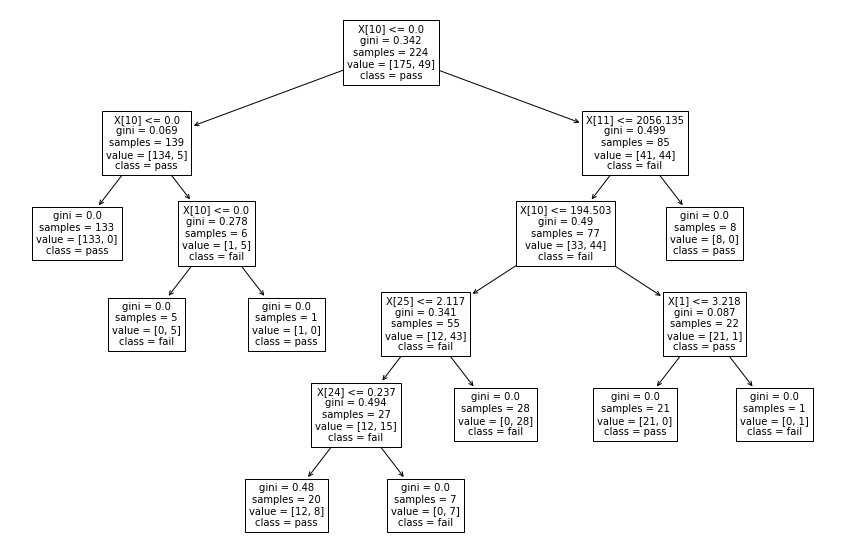

In [ ]:
print(model.feature_importance())
model.plot_tree()
#df.columns[8]

In [ ]:
print(eval_meth)
print(model.evaluate(X_val, y_val, False, True))

within_proj_future
[[42  3]
 [ 1 11]]
{'F1': 0.8461538461538461, 'recall': 0.9166666666666666, 'precision': 0.7857142857142857, 'accuracy': 0.9298245614035088, 'AUC': 0.9249999999999999}


### Saved time
Under cross-project validation, we calculate the build and test time saved by CI-skipping unnecessary commits

In [114]:
# selecting the commits present in the two datasets to create a new DataFrame

valid_proj = 'searchkick'

# classification features
X_train, y_train, X_val, y_val, df, eval_meth = cross_eval(valid_proj+'.csv')
hashes = df['commit_hash']

# time features
project = f'TT-selected-projects/{valid_proj}-TT.csv'
TT_data = pd.DataFrame(pd.read_csv(project))

shared_commits = []
seen = set()
new_columns = list(model.columns_names); new_columns.append('tr_duration')
first_date = "2099-12-31 23:59:59"
last_date = "2000-01-01 00:00:00"

for i, hash_i in enumerate(hashes):
    for j, hash_j in enumerate(TT_data['git_trigger_commit']):
        if hash_i==hash_j and hash_i not in seen:
            seen.add(hash_i)
            date = TT_data['gh_build_started_at'].iloc[j]
            if date<first_date:
                first_date=date
            if date>last_date:
                last_date=date
            shared_commits.append(np.append(df.iloc[i].values, TT_data['tr_duration'].iloc[j]))

new_df = pd.DataFrame(shared_commits, columns=new_columns)
new_df


,ci_skipped,ns,nd,nf,entropy,la,ld,lt,ndev,age,...,classif,prev_com_res,proj_recent_skip,comm_recent_skip,same_committer,is_fix,day_week,CM,commit_hash,tr_duration
0,0,1,1,1,0.000000,10,2,1511.0,32,5.520648,...,1,0,0,0,1,0,4,4.198282,0c85e9123e39bf66af6d4930827fa06abc9d9d01,977.0
1,0,1,1,2,0.979869,10,2,286.0,12,146.429763,...,1,0,0,0,1,0,4,3.215327,6541e44dbb92292338e6129e9f9a64e1baa415f5,1004.0
2,0,1,1,1,0.000000,12,6,1505.0,32,0.421331,...,7,0,0,0,1,0,5,2.437875,69b4aba7b267cb57ffe9355b9be6723660043145,1145.0
3,0,1,1,1,0.000000,1,1,698.0,8,1.439630,...,2,0,0,0,1,1,5,3.868518,ebd9bdfaad16896964acb98b0d53f32e84ea3223,990.0
4,0,1,1,1,0.000000,1,1,876.0,20,0.003113,...,1,0,0,0,1,0,5,4.986396,37298881f2e3a1afb800fed2ba03a111c31b3aff,960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0,1,1,1,0.000000,0,1,208.0,1,0.002859,...,7,0,0,0,1,0,2,5.725761,35dad7d7d4aff285c232a4b9acee9dcc86ed96af,117.0
778,0,1,1,1,0.000000,1,0,207.0,1,0.024560,...,4,0,0,0,1,0,2,6.275068,a20ca339f99fbf5d33fa89375e05f949ed329007,105.0
779,0,1,1,1,0.000000,2,0,420.0,1,0.016412,...,1,0,0,0,1,0,2,5.218048,1202176a09c1869ef2f91d8528f017093e67bbe4,111.0
780,0,1,1,1,0.000000,2,0,130.0,1,0.002766,...,2,0,0,0,1,1,2,2.536265,1f5e60f7630a4f17187ebc492979c49d3685c7d7,125.0


In [115]:
X_val = np.array(df.iloc[:,1:cols_to_keep])
y_val = df.iloc[:,0].astype(int)
total_time = 0; count = 0 ;T=0

for i in range(len(new_df)):
    sample = X_val[i].reshape(1, -1)
    y_pred_i = model.model.predict(sample)
    if y_pred_i==y_val[i]:
        total_time += new_df.iloc[i, -1]
        count += 1
    if y_val[i]==1:
        T += 1

print(f"saved {total_time/60:.2f} hours by CI-Skipping {count} commits ({count/T*100:.2f}%) between {first_date[:10]} and {last_date[:10]}")

saved 3511.67 hours by CI-Skipping 382 commits (93.63%) between 2013-08-12 and 2016-08-31
